# El problema

Una empresa de bicicletas compartidas que opera en el área de una ciudad específica. Tiene un esquema de funcionamiento en el cual los usuarios pueden alquilar una bicicleta desde un lugar en particular y devolverla en un lugar diferente utilizando su infraestructura.

El problema consiste en predecir cuántas bicicletas se van a utilizar en el futuro.
Para ello se nos facilita un archivo [csv](https://drive.google.com/open?id=1gTcb3WZ27DU0nMdvoyPBMYRFK8LU8-rt) donde aparecen el número de bicicletas contratadas
todos los días y las variables metereológicas de esos días.

Se usará análisis de regresión con el fin de  capturar la relación entre características y
número de bicicletas contratadas en un modelo.

# Carga de Datos

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving bikes.csv to bikes.csv
User uploaded file "bikes.csv" with length 54187 bytes


En el fichero CSV, como se ha mencionado, están incluidas las variables metereológicas diarias y el número de bicicletas contratadas.

In [2]:
import pandas as pd
import io
bikes = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),  index_col = 'date')
bikes.head()

,temperature,humidity,windspeed,count
date,,,,
2011-01-03,2.716070,45.715346,21.414957,120.0
2011-01-04,2.896673,54.267219,15.136882,108.0
2011-01-05,4.235654,45.697702,17.034578,82.0
2011-01-06,3.112643,50.237349,10.091568,88.0
2011-01-07,2.723918,49.144928,15.738204,148.0


In [3]:
bikes.shape

(729, 4)

In [4]:
bikes.describe()

,temperature,humidity,windspeed,count
count,729.000000,729.000000,729.000000,729.000000
mean,17.762024,56.514591,17.241418,622.818930
std,8.921313,7.348730,5.222353,383.958772
min,-2.200000,21.300000,5.300000,2.000000
25%,10.066578,51.561669,13.462096,256.333333
50%,18.087694,56.546144,16.656522,639.000000
75%,25.455587,61.423987,20.320807,891.666667
max,35.100000,75.600000,35.200000,1820.000000


<Axes: >

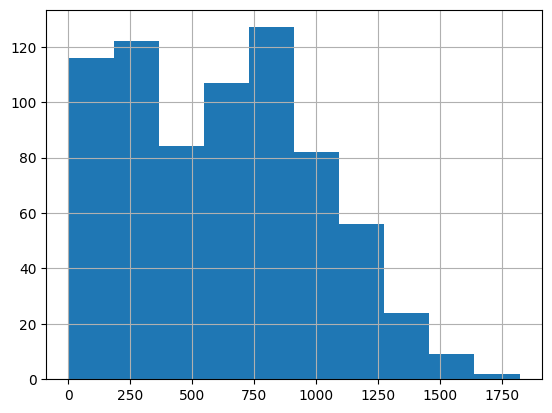

In [5]:
bikes['count'].hist()

## Transformación del problema de regresión a clasificación

<Axes: >

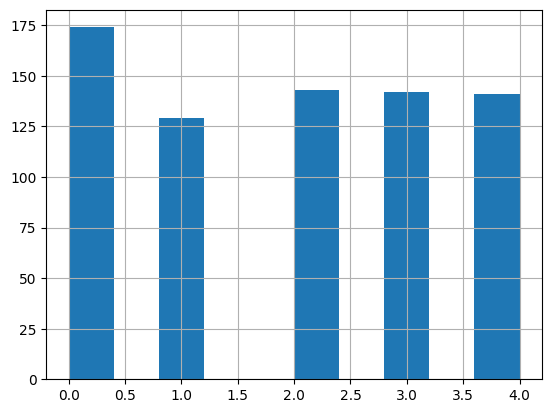

In [6]:
def discretiza(x):
    if x < 250:
        return 0
    elif x < 500:
        return 1
    elif x < 750:
        return 2
    elif x < 1000:
        return 3
    else:
        return 4

bikes['count'] = bikes['count'].map(lambda x: discretiza(x))
bikes['count'].hist()

In [7]:
bikes['count'].unique()

array([0, 1, 2, 3, 4])

# Exploración

Vamos a explorar con estadística básica nuestro conjunto de datos para ver si podemos sacar alguna conclusión

In [8]:
#0.2 Explore Data
# charts from https://machinelearningmastery.com/visualize-machine-learning-data-python-pandas/
import matplotlib.pyplot as plt
plt.rcdefaults()

Los histogramas agrupan los datos en ubicaciones  y proporcionan un recuento de los
número de observaciones en cada caso.
Sirven para identificar la distribución de los datos, y es posible que nos permita también identificación valores atípicos.

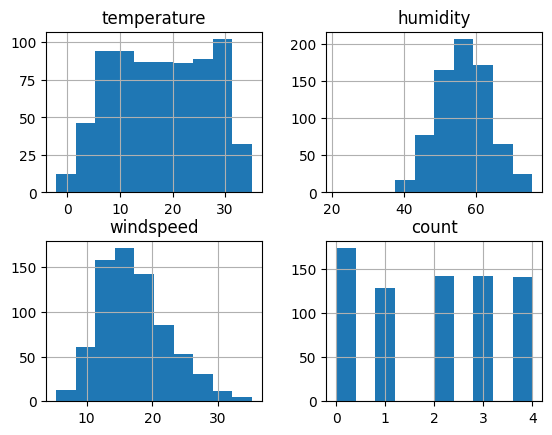

In [9]:
#0.2.1 Univariate Histograms
#
bikes.hist()
plt.show()

Los diagramas de densidad son otra forma de tener una idea rápida de la distribución de cada atributo. Los diagrams parecen *histogramas abstractos* que mediante una curva suve dibujan la distribución de los datos.

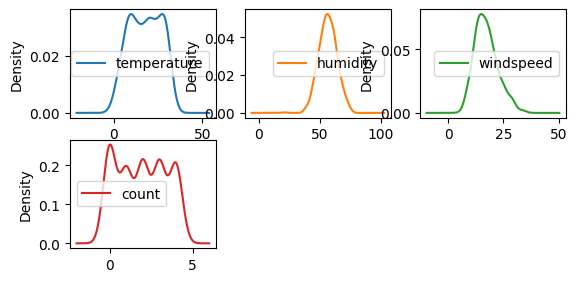

In [10]:
#0.2.2 Density Plots
bikes.plot(kind='density', subplots=True, layout=(3,3), sharex=False)
plt.show()

Un gráfico de dispersión (ScatterPlot) muestra la relación entre dos
variables como puntos en dos  dimensiones, un eje por cada atributo
Las gráficas de dispersión son útiles para detección de relaciones estructuradas
entre variables

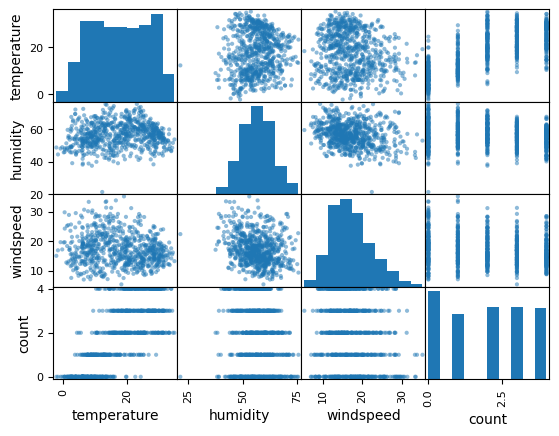

In [11]:
#0.2.3 Scatterplot matrix
from pandas.plotting import scatter_matrix
scatter_matrix(bikes)
plt.show()

Los diagramas de correlación nos indicarán cuan correlacionadas están los atributos predictores con el valor a predecir

<ipython-input-12-7ec38b7c6b52>:2: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


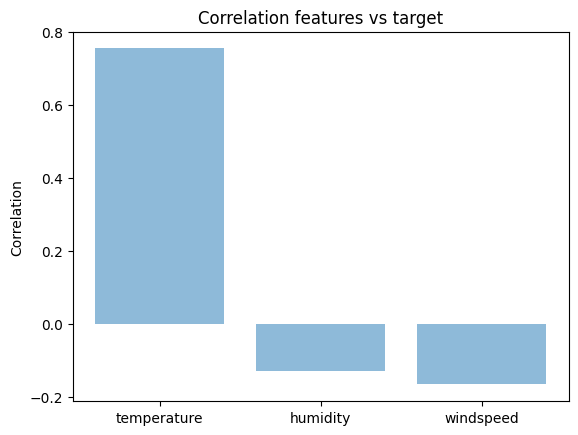

[0.7552917390741912, -0.12827528833287677, -0.1661061231946346]

In [12]:
import numpy as np
from scipy.stats.stats import pearsonr
corr = [pearsonr(bikes['temperature'], bikes['count'])[0], pearsonr(bikes['humidity'], bikes['count'])[0],
        pearsonr(bikes['windspeed'], bikes['count'])[0]]

features= ('temperature', 'humidity', 'windspeed')
y_pos = np.arange(len(features))

plt.bar(y_pos, corr, align='center', alpha=0.5)
plt.xticks(y_pos, features)
plt.ylabel('Correlation')
plt.title('Correlation features vs target')

plt.show()

corr

# Modelado

Vamos a estudiar qué tal se comportan los modelos con el conjunto de entrenamiento usando una, dos y tres variables.

## Modelo con una sola variable

In [13]:
#1.1 Model Parametrization
# criterion: gini
# splitter: best/random
# max_depth: low value avoid overfitting
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=0)

In [14]:
#1.2 Model construction
#model.fit(bikes[['temperature', 'humidity', 'windspeed']], bikes['count'])
# one feature predictor
model.fit(bikes[['temperature']], bikes['count'])

DecisionTreeClassifier(max_depth=10, random_state=0)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


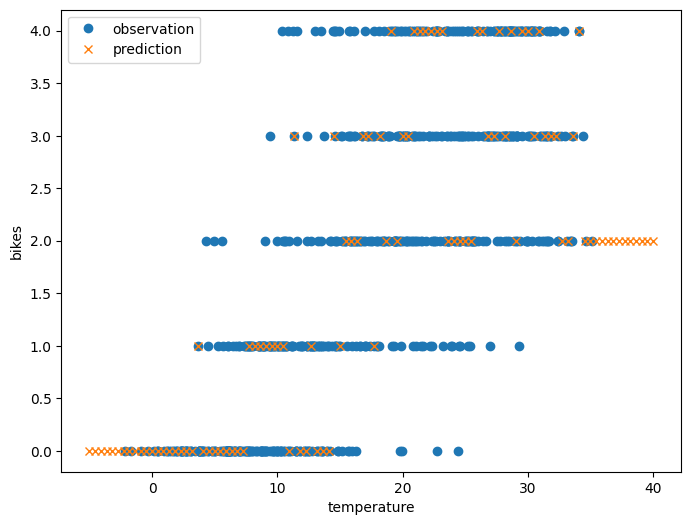

In [15]:
# 2.2 Model Plot
xx = np.array([np.linspace(-5, 40, 100)]).T

plt.figure(figsize=(8,6))
plt.plot(bikes['temperature'], bikes['count'], 'o', label='observation')
plt.plot(xx, model.predict(xx), 'x', label='prediction')
plt.xlabel('temperature')
plt.ylabel('bikes')
plt.legend()
plt.show()

In [16]:
# show classification metrics
from sklearn.metrics import classification_report

y_true = bikes['count']
y_pred = model.predict(bikes[['temperature']])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       174
           1       0.62      0.74      0.68       129
           2       0.60      0.63      0.62       143
           3       0.67      0.52      0.58       142
           4       0.62      0.70      0.66       141

    accuracy                           0.67       729
   macro avg       0.67      0.67      0.66       729
weighted avg       0.68      0.67      0.67       729



In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[130  38   3   2   1]
 [ 16  96   9   1   7]
 [  5  11  90  17  20]
 [  4   5  28  74  31]
 [  3   4  19  17  98]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

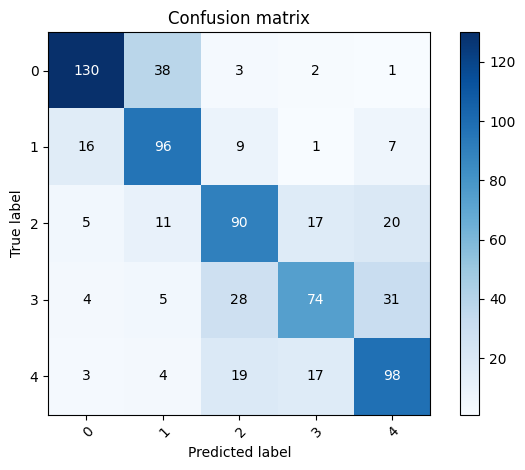

In [18]:
plot_confusion_matrix(y_true, y_pred, normalize=False, classes=model.classes_, title='Confusion matrix')

## Modelo con dos variables

In [19]:
#1.1 Model Parametrization
# criterion: gini
# splitter: best/random
# max_depth: low value avoid overfitting
model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=0)

In [20]:
#1.2 Model construction
model.fit(bikes[['temperature', 'humidity']], bikes['count'])

DecisionTreeClassifier(max_depth=10, random_state=0)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


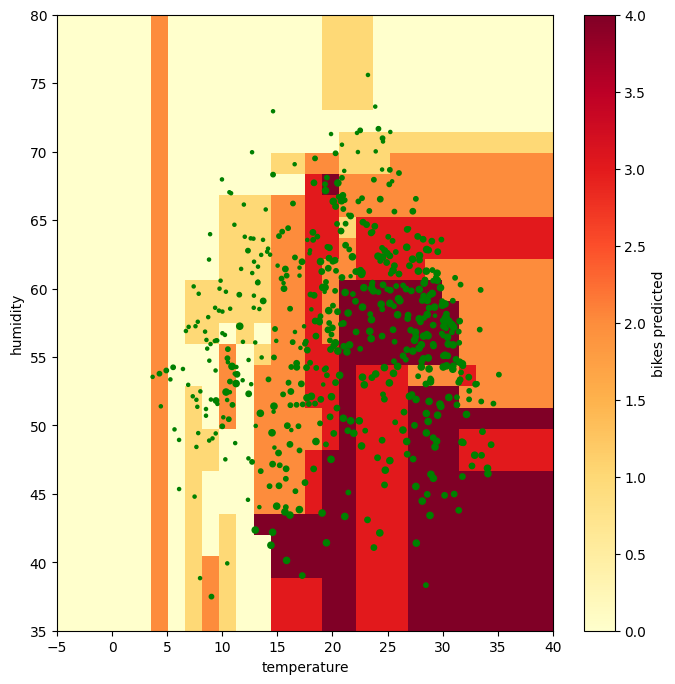

In [21]:
# This visualization is only useful for a model of two predictors

nx = 30
ny = 30
# creating a grid of points
x_temperature = np.linspace(-5, 40, nx)
y_humidity = np.linspace(35, 80, ny)
xx, yy = np.meshgrid(x_temperature, y_humidity)
# evaluating the regresson on all the points
z_bikes = model.predict(np.array([xx.flatten(), yy.flatten()]).T)
zz = np.reshape(z_bikes, (nx, ny))


fig = plt.figure(figsize=(8, 8))
# plotting the predictions
plt.pcolormesh(x_temperature, y_humidity, zz, cmap=plt.cm.YlOrRd)
plt.colorbar(label='bikes predicted') # add a colorbar on the right
# plotting also the observations
plt.scatter(bikes['temperature'], bikes['humidity'], s=bikes['count']*5, c='g')
# setting the limit for each axis
plt.xlim(np.min(x_temperature), np.max(x_temperature))
plt.ylim(np.min(y_humidity), np.max(y_humidity))
plt.xlabel('temperature')
plt.ylabel('humidity')
plt.show()

In [22]:
# show classification metrics
from sklearn.metrics import classification_report

y_true = bikes['count']
y_pred = model.predict(bikes[['temperature', 'humidity']])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       174
           1       0.85      0.81      0.83       129
           2       0.81      0.69      0.75       143
           3       0.62      0.61      0.62       142
           4       0.67      0.76      0.71       141

    accuracy                           0.78       729
   macro avg       0.77      0.77      0.77       729
weighted avg       0.78      0.78      0.78       729



Confusion matrix, without normalization
[[170   4   0   0   0]
 [ 11 104   6   7   1]
 [  2   5  99  19  18]
 [  2   6  13  87  34]
 [  0   3   4  27 107]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

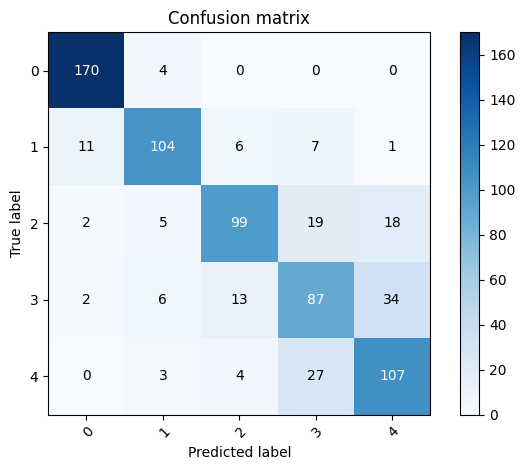

In [23]:
plot_confusion_matrix(y_true, y_pred, normalize=False, classes=model.classes_, title='Confusion matrix')

## Modelo con tres variables

Vamos a construir el modelo con las tres variables y vamos a analizar posteriormente la importancia de las características según el árbol de decisión

In [24]:
#1.2 Model construction
model.fit(bikes[['temperature', 'humidity', 'windspeed']], bikes['count'])

print ('Feature Relevances')
pd.DataFrame({'Attributes': features ,
              'Decision Tree': model.feature_importances_})

Feature Relevances


,Attributes,Decision Tree
0,temperature,0.489109
1,humidity,0.311968
2,windspeed,0.198923


              precision    recall  f1-score   support

           0       0.97      0.94      0.95       174
           1       0.88      0.93      0.90       129
           2       0.82      0.84      0.83       143
           3       0.74      0.75      0.75       142
           4       0.77      0.72      0.74       141

    accuracy                           0.84       729
   macro avg       0.83      0.84      0.84       729
weighted avg       0.84      0.84      0.84       729

Confusion matrix, without normalization
[[163  10   0   1   0]
 [  4 120   4   0   1]
 [  1   3 120  10   9]
 [  0   2  12 107  21]
 [  0   2  10  27 102]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

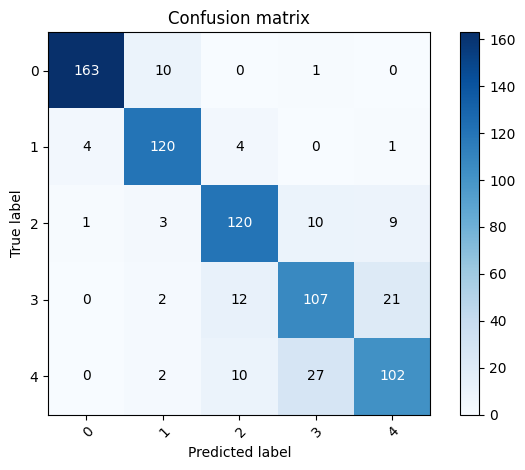

In [25]:
# show classification metrics
from sklearn.metrics import classification_report

y_true = bikes['count']
y_pred = model.predict(bikes[['temperature', 'humidity', 'windspeed']])
print(classification_report(y_true, y_pred))

plot_confusion_matrix(y_true, y_pred, normalize=False, classes=model.classes_, title='Confusion matrix')

# Parametrización

 Antes de proceder a crear los modelos para predecir vamos a dividir nuestro conjunto de datos en dos partes una para entrenamiento (tuning) y otra para test. Para ello vamos a utilizar los datos de 2011 y la mitad de 2012 para entrenamiento y el resto de 2012 para los tests.  

In [26]:
df = bikes[['temperature', 'humidity', 'windspeed', 'count']]

train = df.loc['2011-01-01':'2012-06-30']
test  = df.loc['2012-07-01':]

Un árbol muy profundo aprenderá con muy poco error el valor del conjunto de entrenamiento. Pero el problema está en el sobreaprendizaje, es decir, aprenderemos muy en detalle las observaciones del conjunto de entrenamiento pero seremos muy poco flexibles ante nuevas circunstancias.

Para evitar este sobreaprendizaje vamos a probar a realizar **evaluación cruzada**, es decir, evaluar las parametrizaciones ante diferentes subconjuntos de entrenamiento y de test.

In [27]:
# reset index
train.reset_index(drop = True, inplace = True)
train.head()

,temperature,humidity,windspeed,count
0,2.716070,45.715346,21.414957,0
1,2.896673,54.267219,15.136882,0
2,4.235654,45.697702,17.034578,0
3,3.112643,50.237349,10.091568,0
4,2.723918,49.144928,15.738204,0


Max Depth Value 0.5136363636363637 (9)


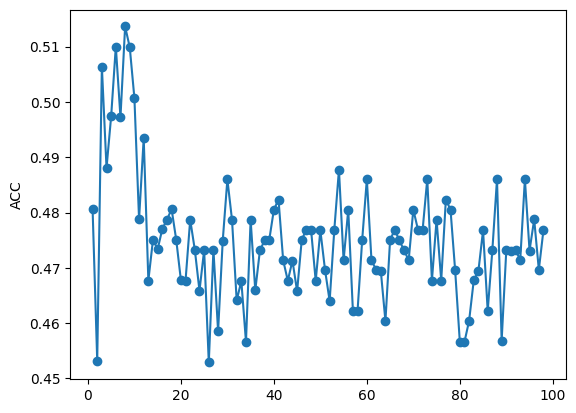

In [28]:
# CROSS VALIDATION ANALYSIS
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = True, random_state=0) #

total_scores = []
for i in range(2, 100):
   model = DecisionTreeClassifier(criterion='gini', max_depth=i)
   fold_accuracy = []
   for train_fold, test_fold in cv.split(train):
      # División train test aleatoria
      f_train = train.loc[train_fold]
      f_test = train.loc[test_fold]
      # entrenamiento y ejecución del modelo
      model.fit( X = f_train.drop(['count'], axis=1), y = f_train['count'])
      y_pred = model.predict(X = f_test.drop(['count'], axis = 1))
      # evaluación del modelo
      acc = accuracy_score(f_test['count'], y_pred)
      fold_accuracy.append(acc)
   total_scores.append(sum(fold_accuracy)/len(fold_accuracy))

max_depth = np.argmax(total_scores) + 2 # +2 porque range(2, 50) y argmax
# devuelve el índice del vector cuyo valor es máximo, y ese vector está indexado comenzando en 0
print ('Max Depth Value ' + str(max(total_scores)) +" (" + str(max_depth) + ")")

plt.plot(range(1,len(total_scores)+1), total_scores,
         marker='o')
plt.ylabel('ACC')

plt.show()

# Construcción y ejecución del modelo



Una vez que hemos identificado la mejor parametrización vamos a pasar a hacer una ejecución del modelo y vamos graficar sus resultados.

Recordamos que al final del paso 1 hemos dividido en entrenamiento/tuneado y test

Posteriormente, vamos a ejecutar el modelo con la mejor parametrización que hayamos obtenido anteriormente

In [29]:
# constructor
model = DecisionTreeClassifier(criterion='gini', max_depth = max_depth)
# fit and predict

model.fit( X = train.drop(['count'], axis=1), y = train['count'])
y_pred = model.predict(X = test.drop(['count'], axis = 1))

In [30]:
y_pred

array([3, 3, 4, 3, 3, 4, 2, 3, 3, 3, 3, 3, 4, 4, 4, 2, 2, 3, 3, 1, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 2, 2,
       3, 2, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 2, 4, 1, 2, 1, 2, 2, 1, 1,
       2, 3, 2, 3, 3, 3, 4, 4, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 3, 1, 4, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

Por último probamos visualizamos como ha quedado nuestra predicción con la realidad.

              precision    recall  f1-score   support

           0       0.30      0.69      0.42        13
           1       0.45      0.50      0.48        38
           2       0.15      0.19      0.17        16
           3       0.32      0.63      0.43        41
           4       0.73      0.11      0.18        76

    accuracy                           0.35       184
   macro avg       0.39      0.42      0.33       184
weighted avg       0.50      0.35      0.31       184

Confusion matrix, without normalization
[[ 9  4  0  0  0]
 [17 19  1  0  1]
 [ 3  9  3  1  0]
 [ 1  4  8 26  2]
 [ 0  6  8 54  8]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

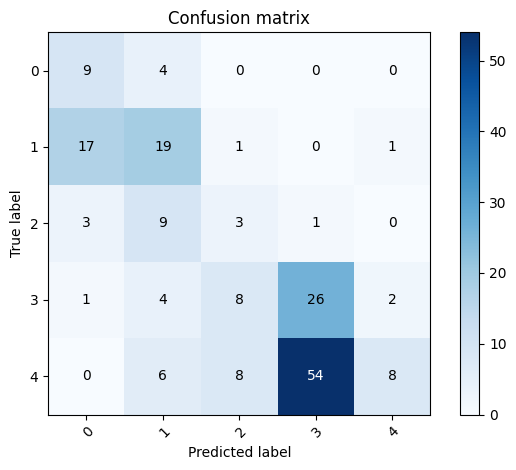

In [31]:
y_true = test['count']
print(classification_report(y_true, y_pred))

plot_confusion_matrix(y_true, y_pred, normalize=False, classes=model.classes_, title='Confusion matrix')

# Referencias

**Exploracion:**

https://machinelearningmastery.com/visualize‐machine‐learning‐data‐python‐pandas/

**Librería:**  
http://scikit‐learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

**Problema y Código:**

https://cambridgespark.com/content/tutorials/getting‐started‐with‐regression‐and‐decision‐trees/index.html

https://cambridgespark.com/content/tutorials/from‐simple‐regression‐to‐multiple‐regression‐with‐decision‐trees/index.html